## Will the Real Donald Trump please stand up?

This jupyter notebook analyzes the Tweets coming from the @RealDonaldTrump account from the inception in 2012 through 25 April. It demonstrates that bag-of-words vectorization with a Linear Support Vector Machine performs very well in predicting when the account is tweeting from an Android device, simply on the text of a Tweet. 

This demonstrates that as @RealDonaldTrump transitioned away from Android use in March and April 2017, it is still likely that he is still tweeting, just from an iPhone. 

In [1]:
import numpy as np
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import re

%matplotlib inline

### Read data in

Thanks http://www.trumptwitterarchive.com/
Before run, scrape to raw_tweets.txt.

Parse out thee datetime, device, and tweet. Read into a dataframe. Remove URLs.

In [2]:
#read the data from raw files into a data frame
def readIn(file):
    # Create regex to parse out date, device tag, and tweet text
    datetime_regex = '[A-z]{3} [0-9]{1,2}, 20[0-9]{2} [0-9]{2}:[0-9]{2}:[0-9]{2} [A-Z]{2}'
    device_regex = '\[([A-Za-z0-9 _\(\)\-]*)\]' #[A-Za-z0-9 _\(\)]
    tweet_regex = '[0-9]{2}:[0-9]{2}:[0-9]{2} [A-Z]{2}(.*)\['
    # these will be the headers for the pandas data frames
    h = ["date","tweet","device"] 
    file_name = file
    newFile = open (file_name, "rb")
    f = newFile.read()
    newFile.close()
    out=[]
    # the lines in the file are seperated by '\r\n' and the first couple of lines are header text
    for i in f.decode('utf-8').split('\r\n')[12:]:
        dt = re.search(datetime_regex,i).group(0)
        dev = re.findall(device_regex,i)[-1]       
        tw = re.search(tweet_regex,i).group(1)
        out.append([dt,tw,dev])
    df = pd.DataFrame(out,columns=h)
    return df

In [3]:
df = readIn('raw_tweets.txt')
df['datetime'] = pd.to_datetime(df['date'],format= '%b %d, %Y %I:%M:%S %p')
df = df.set_index(df['datetime'])
df['day'] = df.index.round('D')  
df['Android'] = np.where(df.device.str.contains('Android') ,1, 0)
df['tweet'] = df['tweet'].str.replace('http[-a-zA-Z0-9@:%._\+~#=/]+','URL')

### Let's analyze the tweets a bit

The first and last time he used an Android.

In [4]:
fsls = df.groupby(['Android']).datetime.agg({'date ': ['first', 'last']})
fsls

date                     
                      first                last
Android                                        
0       2017-04-25 07:36:28 2012-11-08 14:07:38
1       2017-03-25 09:41:14 2013-02-05 20:53:40

This is when he was phasing out the Android.

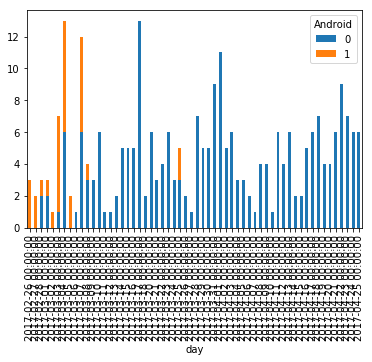

In [5]:
df2 = df.head(270).groupby(['day','Android'])['day'].count().unstack('Android').fillna(0)
df2[[0,1]].plot(kind='bar', stacked=True)

Frequency of tweet by day.

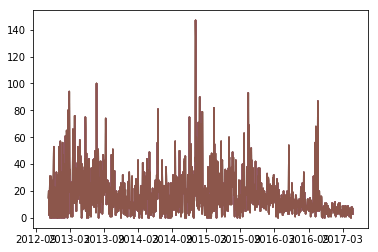

In [6]:
plt.plot(df.resample('D').count())

### Prep the data for training.

- Remove retweets
- Remove Twitter Web Client tweets (too ambiguous)
- Remove all the numbers from tweets

In [7]:
#take out all of the retweets
df = df[~df['tweet'].str.contains('\"@[A-Za-z0-9_]+: ')]
df = df[~df['tweet'].str.contains('RT @[A-Za-z0-9_]+: ')]
# Take out the Twitter Web Client tweets out
df = df[~df['device'].str.contains('Twitter Web Client')]
#remove all of the numbers from the tweets
df['tweet'] = df['tweet'].str.replace('(\d+)','')


### Create an 80/20 training set
Only keep data before 25 February 2017 (the period when he is using an Android)

In [8]:
train_percent =  0.8 
dft = df.ix[datetime.date(year=2017,month=2,day=25):]
print(len(dft))
msk = np.random.rand(len(dft))< train_percent
train = dft[msk]
test = dft[~msk]

7628


Devices used in this time period

In [9]:
dft.groupby('device').count()

date  tweet  datetime   day  Android
device                                                        
Facebook                    74     74        74    74       74
Instagram                  133    133       133   133      133
Media Studio                 1      1         1     1        1
Mobile Web (M5)             55     55        55    55       55
Neatly For BlackBerry 10     5      5         5     5        5
Periscope                    7      7         7     7        7
TweetDeck                    2      2         2     2        2
TwitLonger Beta              3      3         3     3        3
Twitlonger                  23     23        23    23       23
Twitter Ads                 64     64        64    64       64
Twitter Mirror for iPad      1      1         1     1        1
Twitter QandA               10     10        10    10       10
Twitter for Android       4816   4816      4816  4816     4816
Twitter for BlackBerry      96     96        96    96       96
Twitter for Websites         1      1         1     1        1
Twitter for iPad            20     20        20    20       20
Twitter for iPhone        2307   2307      2307  2307     2307
Vine - Make a Scene         10     10        10    10       10

In [10]:
percent_android = len(dft[dft['device']=='Twitter for Android'])/len(dft)
print(percent_android)

0.6313581541688515


### Vecorize 
- Simple boolean 
- Keep case (DT likes to yell)

In [11]:
count_vectorizer = CountVectorizer( lowercase=False)
counts = count_vectorizer.fit_transform(train['tweet'].values)

In [12]:
print(count_vectorizer.get_feature_names()[:10])

['ABC', 'ABCPolitics', 'ABCWashington', 'ABOUT', 'AC', 'ACCEPTANCE', 'ACT', 'ACTION', 'ADMINISTRATION', 'ADMIRALS']


### Label

In [13]:
label =  np.where(train.device.str.contains('Android') ,1, 0)

### Train the model

In [14]:
# use a vanilla SVM
svm = SVC(kernel='linear',probability=True)
svm.fit(counts, label)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Test the model

In [15]:
# we use the same vectorizor here so the indexing of the vocab is the same
test_counts = count_vectorizer.transform(test['tweet'].values)
print('The 1000th index for the testing set corresponds to: '+str(count_vectorizer.get_feature_names()[1000]))

test_label = np.where(test.device.str.contains('Android') ,1,0)
#test the svm model on the test data
predictions = svm.predict(test_counts)
pred_prob = svm.predict_proba(test_counts)


The 1000th index for the testing set corresponds to: DEFENSE


### Performance

In [16]:
confusion = confusion_matrix(test_label, predictions)

recall = confusion[1][1]/(confusion[1][1]+confusion[0][1])
percision = confusion[1][1]/(confusion[1][1]+confusion[1][0])
score =(2*percision*recall)/(percision+recall)


print('The confusion matrix associated with the SVM model is: '+str(confusion))
print('The percision associated with the SVM model is: '+str(percision))
print('The recall associated with the SVM model is: '+str(recall))
print('The F score associated with the SVM model is: '+str(score))

The confusion matrix associated with the SVM model is: [[467 122]
 [ 58 873]]
The percision associated with the SVM model is: 0.937701396348
The recall associated with the SVM model is: 0.877386934673
The F score associated with the SVM model is: 0.906542056075


### Discriminating words

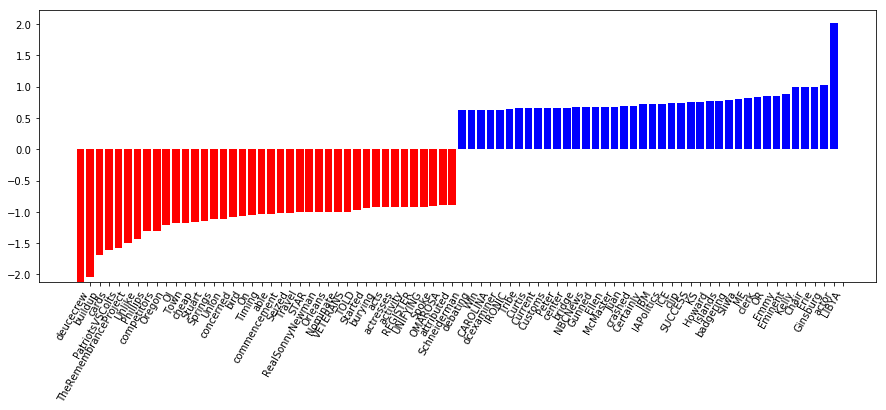

In [17]:
coef = svm.coef_.data
top_features = 40
feature_names = count_vectorizer.get_feature_names()
top_positive_coefficients = np.argsort(coef)[-top_features:]
top_negative_coefficients = np.argsort(coef)[:top_features]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
plt.figure(figsize=(15, 5))
colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
feature_names = np.array(feature_names)
plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
plt.show()

### Example perdictions -- Sanity Check

In [18]:
test['predictions'] = predictions
test['pred_prob'] = list(pred_prob)
test

C:\Users\Michelle Lee\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Michelle Lee\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


date  \
datetime                                        
2017-02-24 12:04:19  Feb 24, 2017 12:04:19 PM   
2017-02-23 19:01:40  Feb 23, 2017 07:01:40 PM   
2017-02-22 07:50:56  Feb 22, 2017 07:50:56 AM   
2017-02-22 07:20:40  Feb 22, 2017 07:20:40 AM   
2017-02-21 18:23:13  Feb 21, 2017 06:23:13 PM   
2017-02-17 16:32:29  Feb 17, 2017 04:32:29 PM   
2017-02-17 06:43:10  Feb 17, 2017 06:43:10 AM   
2017-02-17 05:13:32  Feb 17, 2017 05:13:32 AM   
2017-02-15 08:13:10  Feb 15, 2017 08:13:10 AM   
2017-02-15 07:28:37  Feb 15, 2017 07:28:37 AM   
2017-02-15 07:19:18  Feb 15, 2017 07:19:18 AM   
2017-02-14 15:21:59  Feb 14, 2017 03:21:59 PM   
2017-02-14 09:28:54  Feb 14, 2017 09:28:54 AM   
2017-02-13 13:50:57  Feb 13, 2017 01:50:57 PM   
2017-02-12 08:04:49  Feb 12, 2017 08:04:49 AM   
2017-02-12 06:55:10  Feb 12, 2017 06:55:10 AM   
2017-02-11 18:15:34  Feb 11, 2017 06:15:34 PM   
2017-02-11 08:33:53  Feb 11, 2017 08:33:53 AM   
2017-02-11 08:18:43  Feb 11, 2017 08:18:43 AM   
2017-02-10 18:24:51  Feb 10, 2017 06:24:51 PM   
2017-02-09 08:31:59   Feb 9, 2017 08:31:59 AM   
2017-02-08 17:07:18   Feb 8, 2017 05:07:18 PM   
2017-02-07 20:04:00   Feb 7, 2017 08:04:00 PM   
2017-02-06 21:33:55   Feb 6, 2017 09:33:55 PM   
2017-02-05 22:36:54   Feb 5, 2017 10:36:54 PM   
2017-02-03 06:24:51   Feb 3, 2017 06:24:51 AM   
2017-02-02 12:29:16   Feb 2, 2017 12:29:16 PM   
2017-02-01 22:55:49   Feb 1, 2017 10:55:49 PM   
2017-02-01 07:50:16   Feb 1, 2017 07:50:16 AM   
2017-01-30 16:07:52  Jan 30, 2017 04:07:52 PM   
...                                       ...   
2013-02-25 20:02:07  Feb 25, 2013 08:02:07 PM   
2013-02-25 19:45:47  Feb 25, 2013 07:45:47 PM   
2013-02-25 06:18:46  Feb 25, 2013 06:18:46 AM   
2013-02-25 06:04:27  Feb 25, 2013 06:04:27 AM   
2013-02-25 00:07:16  Feb 25, 2013 12:07:16 AM   
2013-02-24 15:52:08  Feb 24, 2013 03:52:08 PM   
2013-02-23 18:25:52  Feb 23, 2013 06:25:52 PM   
2013-02-22 19:58:45  Feb 22, 2013 07:58:45 PM   
2013-02-22 19:22:01  Feb 22, 2013 07:22:01 PM   
2013-02-22 18:31:06  Feb 22, 2013 06:31:06 PM   
2013-02-20 22:43:37  Feb 20, 2013 10:43:37 PM   
2013-02-20 22:37:16  Feb 20, 2013 10:37:16 PM   
2013-02-20 22:25:42  Feb 20, 2013 10:25:42 PM   
2013-02-20 19:33:36  Feb 20, 2013 07:33:36 PM   
2013-02-20 18:42:22  Feb 20, 2013 06:42:22 PM   
2013-02-20 18:04:55  Feb 20, 2013 06:04:55 PM   
2013-02-20 17:50:42  Feb 20, 2013 05:50:42 PM   
2013-02-20 00:13:01  Feb 20, 2013 12:13:01 AM   
2013-02-19 07:36:19  Feb 19, 2013 07:36:19 AM   
2013-02-14 15:59:40  Feb 14, 2013 03:59:40 PM   
2013-02-11 15:43:56  Feb 11, 2013 03:43:56 PM   
2013-02-08 08:02:15   Feb 8, 2013 08:02:15 AM   
2013-01-21 08:39:18  Jan 21, 2013 08:39:18 AM   
2013-01-21 08:36:05  Jan 21, 2013 08:36:05 AM   
2013-01-18 10:09:13  Jan 18, 2013 10:09:13 AM   
2013-01-01 10:20:23   Jan 1, 2013 10:20:23 AM   
2013-01-01 10:13:14   Jan 1, 2013 10:13:14 AM   
2012-12-19 13:55:43  Dec 19, 2012 01:55:43 PM   
2012-12-14 13:29:47  Dec 14, 2012 01:29:47 PM   
2012-11-14 14:10:25  Nov 14, 2012 02:10:25 PM   

                                                                 tweet  \
datetime                                                                 
2017-02-24 12:04:19   Trump vows to fight 'epidemic' of human traff...   
2017-02-23 19:01:40   Seven people shot and killed yesterday in Chi...   
2017-02-22 07:50:56   Very much enjoyed my tour of the Smithsonian'...   
2017-02-22 07:20:40   One thing I will say about Rep. Keith Ellison...   
2017-02-21 18:23:13   The so-called angry crowds in home districts ...   
2017-02-17 16:32:29   The FAKE NEWS media (failing @nytimes, @CNN, ...   
2017-02-17 06:43:10   Thank you for all of the nice statements on t...   
2017-02-17 05:13:32   Despite the long delays by the Democrats in f...   
2017-02-15 08:13:10   The real scandal here is that classified info...   
2017-02-15 07:28:37   Thank you to Eli Lake of The Bloomberg View -...   
2017-02-15 07:19:18   Information is being illegally given to the

### Actual device use

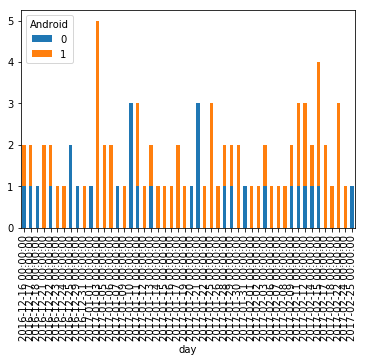

In [19]:
df2 = test.groupby(['day','Android'])['day'].count().unstack('Android').fillna(0)

df2[[0,1]].tail(50).plot(kind='bar', stacked=True)

### Predicted device use

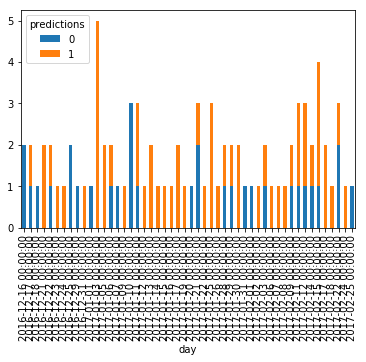

In [20]:
df2 = test.groupby(['day','predictions'])['day'].count().unstack('predictions').fillna(0)

df2[[0,1]].tail(50).plot(kind='bar', stacked=True)

### Let's perdict the future!!

Run the trained model on the data after he stoped using an Android, from 25 February 2017 to 25 April 2017

In [21]:
test = df.ix[:datetime.date(year=2017,month=2,day=25)]
len(test)

252

In [22]:
# we use the same vectorizor here so the indexing of the vocab is the same
test_counts = count_vectorizer.transform(test['tweet'].values)
print('The 1000th index for the testing set corresponds to: '+str(count_vectorizer.get_feature_names()[1000]))

test_label = np.where(test.device.str.contains('Android') ,1,0)
#test the svm model on the test data
predictions = svm.predict(test_counts)
test['predictions'] = predictions

The 1000th index for the testing set corresponds to: DEFENSE


C:\Users\Michelle Lee\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### The data as tagged by Android v. Non-Android on twitter by day

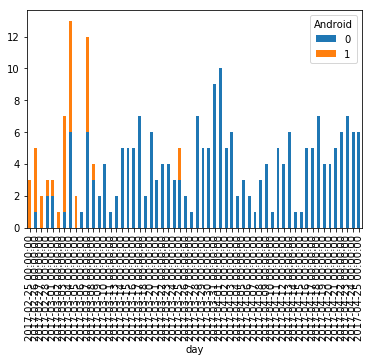

In [23]:
df2 = test.groupby(['day','Android'])['day'].count().unstack('Android').fillna(0)
df2
df2[[0,1]].plot(kind='bar', stacked=True)

### Predicted device use 

Even though he essentially stopped using an Android after February 2017, his Android-like voice lives on!

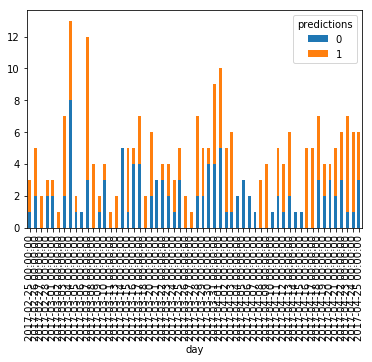

In [24]:
df2 = test.groupby(['day','predictions'])['day'].count().unstack('predictions').fillna(0)
df2
df2[[0,1]].plot(kind='bar', stacked=True)

In [25]:
test

date  \
datetime                                        
2017-04-25 07:36:28  Apr 25, 2017 07:36:28 AM   
2017-04-25 07:30:15  Apr 25, 2017 07:30:15 AM   
2017-04-25 06:23:08  Apr 25, 2017 06:23:08 AM   
2017-04-24 15:32:08  Apr 24, 2017 03:32:08 PM   
2017-04-24 12:18:32  Apr 24, 2017 12:18:32 PM   
2017-04-24 12:11:31  Apr 24, 2017 12:11:31 PM   
2017-04-24 10:31:57  Apr 24, 2017 10:31:57 AM   
2017-04-24 09:02:01  Apr 24, 2017 09:02:01 AM   
2017-04-24 07:28:01  Apr 24, 2017 07:28:01 AM   
2017-04-24 07:15:45  Apr 24, 2017 07:15:45 AM   
2017-04-23 14:55:04  Apr 23, 2017 02:55:04 PM   
2017-04-23 14:48:16  Apr 23, 2017 02:48:16 PM   
2017-04-23 10:44:59  Apr 23, 2017 10:44:59 AM   
2017-04-23 10:42:07  Apr 23, 2017 10:42:07 AM   
2017-04-23 09:20:12  Apr 23, 2017 09:20:12 AM   
2017-04-23 09:07:52  Apr 23, 2017 09:07:52 AM   
2017-04-23 09:05:07  Apr 23, 2017 09:05:07 AM   
2017-04-22 16:49:10  Apr 22, 2017 04:49:10 PM   
2017-04-22 14:01:59  Apr 22, 2017 02:01:59 PM   
2017-04-22 11:15:01  Apr 22, 2017 11:15:01 AM   
2017-04-22 11:10:26  Apr 22, 2017 11:10:26 AM   
2017-04-22 11:05:37  Apr 22, 2017 11:05:37 AM   
2017-04-21 22:38:00  Apr 21, 2017 10:38:00 PM   
2017-04-21 19:43:21  Apr 21, 2017 07:43:21 PM   
2017-04-21 15:22:14  Apr 21, 2017 03:22:14 PM   
2017-04-21 08:04:19  Apr 21, 2017 08:04:19 AM   
2017-04-21 05:50:33  Apr 21, 2017 05:50:33 AM   
2017-04-21 05:32:01  Apr 21, 2017 05:32:01 AM   
2017-04-20 16:35:05  Apr 20, 2017 04:35:05 PM   
2017-04-20 14:33:46  Apr 20, 2017 02:33:46 PM   
...                                       ...   
2017-03-03 17:13:10   Mar 3, 2017 05:13:10 PM   
2017-03-03 16:02:23   Mar 3, 2017 04:02:23 PM   
2017-03-03 15:49:53   Mar 3, 2017 03:49:53 PM   
2017-03-03 15:48:21   Mar 3, 2017 03:48:21 PM   
2017-03-03 15:47:30   Mar 3, 2017 03:47:30 PM   
2017-03-03 12:54:30   Mar 3, 2017 12:54:30 PM   
2017-03-03 11:41:55   Mar 3, 2017 11:41:55 AM   
2017-03-03 07:19:12   Mar 3, 2017 07:19:12 AM   
2017-03-03 07:00:39   Mar 3, 2017 07:00:39 AM   
2017-03-02 21:38:48   Mar 2, 2017 09:38:48 PM   
2017-03-02 21:35:33   Mar 2, 2017 09:35:33 PM   
2017-03-02 21:27:29   Mar 2, 2017 09:27:29 PM   
2017-03-02 21:22:49   Mar 2, 2017 09:22:49 PM   
2017-03-02 06:00:41   Mar 2, 2017 06:00:41 AM   
2017-03-01 08:38:44   Mar 1, 2017 08:38:44 AM   
2017-02-28 20:42:16  Feb 28, 2017 08:42:16 PM   
2017-02-28 20:30:49  Feb 28, 2017 08:30:49 PM   
2017-02-27 21:43:03  Feb 27, 2017 09:43:03 PM   
2017-02-27 16:48:21  Feb 27, 2017 04:48:21 PM   
2017-02-27 12:06:23  Feb 27, 2017 12:06:23 PM   
2017-02-26 15:13:52  Feb 26, 2017 03:13:52 PM   
2017-02-26 13:16:41  Feb 26, 2017 01:16:41 PM   
2017-02-26 06:42:39  Feb 26, 2017 06:42:39 AM   
2017-02-26 06:33:16  Feb 26, 2017 06:33:16 AM   
2017-02-25 17:02:22  Feb 25, 2017 05:02:22 PM   
2017-02-25 16:53:21  Feb 25, 2017 04:53:21 PM   
2017-02-25 13:12:25  Feb 25, 2017 01:12:25 PM   
2017-02-25 08:27:04  Feb 25, 2017 08:27:04 AM   
2017-02-25 08:19:18  Feb 25, 2017 08:19:18 AM   
2017-02-25 07:25:24  Feb 25, 2017 07:25:24 AM   

                                                                 tweet  \
datetime                                                                 
2017-04-25 07:36:28   Don't let the fake media tell you that I have...   
2017-04-25 07:30:15   Canada has made business for our dairy farmer...   
2017-04-25 06:23:08   Proud of @IvankaTrump for her leadership on t...   
2017-04-24 15:32:08   Today, I signed the Holocaust Remembrance Pro...   
2017-04-24 12:18:32   If our healthcare plan is approved, you will ...   
2017-04-24 12:11:31   Join me in congratulating @NASA's @AstroPeggy...   
2017-04-24 10:31:57   ....the wall is not built, which it will be, ...   
2017-04-24 09:02:01                               #CongratsPeggy! URL    
2017-04-24 07:28:01   The Wall is a very important tool in stopping...   
2017-04-24 07:15:45   The two fake news polls released yesterday, A...   
2017-04-23 14:55:04   ...popular vote. ABC News/Washington Post P